In [7]:
import math

from matplotlib import pyplot as plt

In [23]:
def normal_cdf(z, mu=0, sigma=1):
    return (1 + math.erf((z - mu) / math.sqrt(2) / sigma)) / 2

In [24]:
print(normal_cdf(1))
print(normal_cdf(-1))
print(normal_cdf(-2))
print(normal_cdf(-3))

0.8413447460685428
0.15865525393145713
0.022750131948179153
0.0013498980316301035


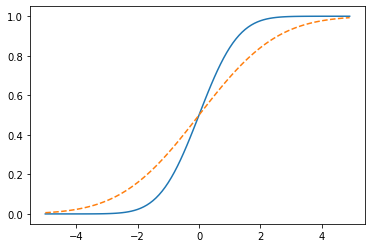

In [47]:
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs, [normal_cdf(x, sigma=1) for x in xs], '-', label='mu=0,sigma=1')
plt.plot(xs, [normal_cdf(x, sigma=2) for x in xs], '--', label='mu=0,sigma=2')
plt.show()

In [34]:
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """ Find approx inverse using binary search """
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z, low_p = -10.0, 0
    hi_z, hi_p = 10, 0
    
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2
        mid_p = normal_cdf(mid_z)
        
        if mid_p < p:
            # midpoint too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break
    return mid_z

In [44]:
print(inverse_normal_cdf(0.8413)) # find +1 sigma

print(inverse_normal_cdf(0.1586))
print(inverse_normal_cdf(0.02275))
print(inverse_normal_cdf(0.00134))

print(inverse_normal_cdf(1 - 0.1586))
print(inverse_normal_cdf(1 - 0.02275))
print(inverse_normal_cdf(1- 0.00134))

0.9998226165771484
-1.000223159790039
-1.9999980926513672
-3.0022335052490234
1.000223159790039
1.9999980926513672
3.0022335052490234


In [36]:
def normal_approximation_to_binomial(n, p):
    """ finds mu and sigma corresponding to a Binomial(n, p)"""
    mu = n * p
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma 

In [37]:
# the normal cds is the probability that the variable is below a threshold
normal_probability_below = normal_cdf

# it's above the threshold if it's not below the threashold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# it's between if it's less than hi, more than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# it's outside if it's not in between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

In [63]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """ z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability, mu=0, sigma=1):
    """ z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """ returns the symmetric (about the mean) bounds
    that contain probability"""
    tail_probability = (1 - probability) / 2
    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    
    # lower  bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    
    return lower_bound, upper_bound

## Significance testing

We will consider testing a coin for fairness

H_0: the coin is fair (p = 0.5)

Our test will flip the coin n times and count the number of heads X. 
Each flip is a Bernoulli trial, which means X (n flips) is a Binomial(n, p)

In [64]:
# We choose to flip the coin 1000 times

mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


### Decision about significance

Significance - How willing we are to make a type I error ("false positive") in which we reject H_0 even though it's true

Let's choose 5% as our wilingness to make a type I error

Consider the test that rejects H_0 if X fallse outside the bounds given by:

In [65]:
normal_two_sided_bounds(0.95, mu_0, sigma_0)

(469.01026640487555, 530.9897335951244)

Assuming p really is 0.5 (H_0 is true) there is just a 5% chance we observe an X that lies outside this (469, 531) interval.

### Test power

Power is the probability of not making a type 2 error (a false negative), in which we fail to reject H_0 even if it's false.

We have to specify what exactly H_0 being false means for our test. Let's check what happens if p is really 0.55

In [66]:
# 95% bounds based on assumption p is 0.55

lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(lo, hi)

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print(mu_1, sigma_1)

# a type 2 error means we fail to reject the null hypothesys
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
print(type_2_probability)

power = 1 - type_2_probability
power

469.01026640487555 530.9897335951244
550.0 15.732132722552274
0.11345199870463285


0.8865480012953671

## Confidence intervals

A third approach is to construct a confidence interval around the observed value of the parameter - in our problem, the p(heads) of the coin under test.

We can construct the confidence interval by modelling p as a normal distribution with average mu and dev sigma:

In [67]:
# We observed 525 heads in 1000 flips
p_hat = 525 / 1000 # observed value of p
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
print(mu, sigma)

0.525 0.015791611697353755


In [68]:
# the interval

normal_two_sided_bounds(0.95, mu, sigma)

(0.4940490278129096, 0.5559509721870904)

p=0.5 lies within the interval, so we should not reject H_0

In [69]:
# We observed 525 heads in 1000 flips
p_hat = 540 / 1000 # observed value of p
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
print(mu, sigma)

normal_two_sided_bounds(0.95, mu, sigma)

0.54 0.015760710643876435


(0.5091095927295919, 0.5708904072704082)

p=0.5 lies outside the interval, so we should reject H_0

## P-hacking

A procedure that erroneusly rejects the null hypothesis 5% percent of the time will - by definition - 5% of the time erroneously reject the null hypothesis:

In [82]:
import random


def run_experiment():
    """ flip a fair coin 1000 times, True=heads """
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment):
    """using the 5% significance levels 469, 531 """
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0) # repeatability between runs

experiments = [run_experiment() for _ in range(1000)]

num_rejections = len([experiment for experiment in experiments if reject_fairness(experiment)])
num_rejections

46

## Bayesian Inference

    

In [93]:
def B(alpha, beta):
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)
    
def beta_pdf(x, alpha, beta):
    if x < 0 or x > 1:
        return 0
    return (x ** (alpha - 1)) * ((1 - x) ** (beta - 1)) / B(alpha, beta)

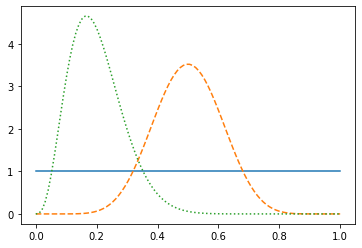

In [97]:
import numpy as np

def visualize_distribution(curried_distribution_functions, xmin=0.0, xmax=1.0):
    xs = np.linspace(xmin, xmax, 100, endpoint=True)
    signs = ['-', '--', ':', '-']
    for ix, dfunc in enumerate(curried_distribution_functions):
        plt.plot(xs, [dfunc(x) for x in xs], signs[ix])
    plt.show()


visualize_distribution([
    lambda x: beta_pdf(x, 1, 1),
    lambda x: beta_pdf(x, 10, 10),
    lambda x: beta_pdf(x, 4, 16),
])

In [98]:
def get_posterior_after_flips(alpha, beta, flips, heads):
    return alpha + heads, beta + flips - heads

### FIrst experiment, starting with uniform prior

Prior is beta(1, 1), horizontal line, approx uniform

Every time we flip 10 times, we get 3 heads.

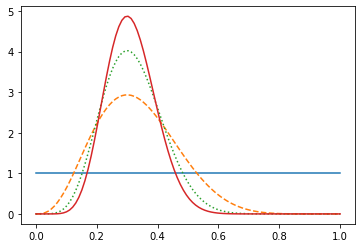

In [118]:
alpha_0, beta_0 = 1, 1
distributions = [(alpha_0, beta_0)]

# after 10 flips
alpha_1, beta_1 = get_posterior_after_flips(alpha_0, beta_0, 10, 3)
distributions.append((alpha_1, beta_1))

# after 10 more flips
alpha_2, beta_2 = get_posterior_after_flips(alpha_1, beta_1, 10, 3)
distributions.append((alpha_2, beta_2))

# after 10 more flips
alpha_3, beta_3 = get_posterior_after_flips(alpha_2, beta_2, 10, 3)
distributions.append((alpha_3, beta_3))

# Visualize
curried_funcs = [(lambda x, a=a, b=b: beta_pdf(x, a, b)) for a, b in distributions]

visualize_distribution(curried_funcs)

### Second experiment, starting with Beta(20, 20)

Prior centers around 0.5

Every time we flip 10 times, we get 3 heads.

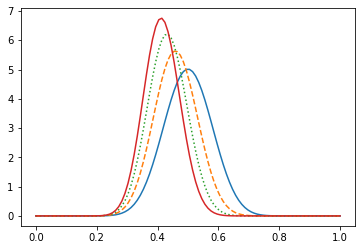

In [119]:
alpha_0, beta_0 = 20, 20
distributions = [(alpha_0, beta_0)]

# after 10 flips
alpha_1, beta_1 = get_posterior_after_flips(alpha_0, beta_0, 10, 3)
distributions.append((alpha_1, beta_1))

# after 10 more flips
alpha_2, beta_2 = get_posterior_after_flips(alpha_1, beta_1, 10, 3)
distributions.append((alpha_2, beta_2))

# after 10 more flips
alpha_3, beta_3 = get_posterior_after_flips(alpha_2, beta_2, 10, 3)
distributions.append((alpha_3, beta_3))

# Visualize
curried_funcs = [(lambda x, a=a, b=b: beta_pdf(x, a, b)) for a, b in distributions]

visualize_distribution(curried_funcs)

In [ ]:
### Second experiment, starting with Beta(55, 45)

Prior centers around 0.55

Every time we flip 10 times, we get 3 heads.

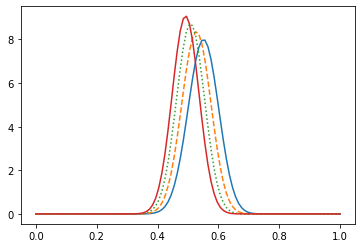

In [120]:
alpha_0, beta_0 = 55, 45
distributions = [(alpha_0, beta_0)]

# after 10 flips
alpha_1, beta_1 = get_posterior_after_flips(alpha_0, beta_0, 10, 3)
distributions.append((alpha_1, beta_1))

# after 10 more flips
alpha_2, beta_2 = get_posterior_after_flips(alpha_1, beta_1, 10, 3)
distributions.append((alpha_2, beta_2))

# after 10 more flips
alpha_3, beta_3 = get_posterior_after_flips(alpha_2, beta_2, 10, 3)
distributions.append((alpha_3, beta_3))

# Visualize
curried_funcs = [(lambda x, a=a, b=b: beta_pdf(x, a, b)) for a, b in distributions]

visualize_distribution(curried_funcs)